In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

Importing from cleaned data notebook

In [2]:
data = pd.read_csv('data_clean.csv')

In [3]:
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,range
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,792.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,327.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,222.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1341.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,1775.0


In [4]:
data.shape

(18000, 13)

Removing Outliers

<AxesSubplot:>

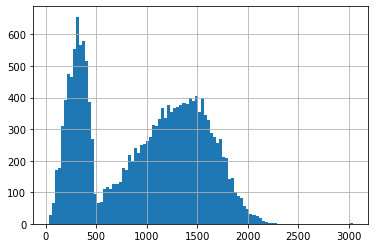

In [5]:
data['range'].hist(bins=100)

<AxesSubplot:>

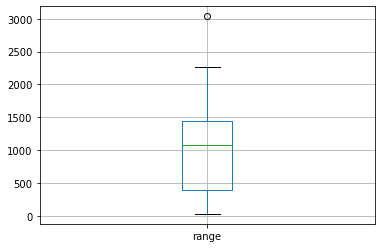

In [6]:
data.boxplot(column=['range'])

<AxesSubplot:>

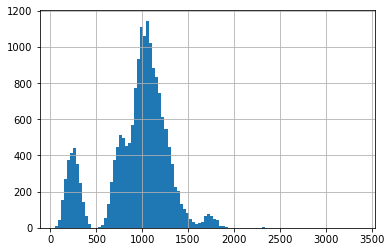

In [7]:
data['average_balance'].hist(bins=100)

<AxesSubplot:>

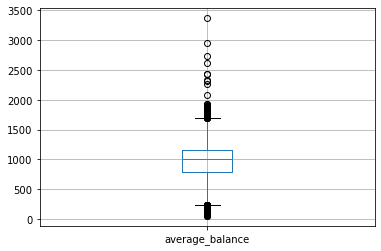

In [8]:
data.boxplot(column=['average_balance'])

In [9]:
iqr = np.percentile(data['average_balance'],75) - np.percentile(data['average_balance'],25)
upper_limit = np.percentile(data['average_balance'],75) + 2*iqr
lower_limit = np.percentile(data['average_balance'],25) - 2*iqr
data_bal_iqr =data[(data['average_balance']>lower_limit) & (data['average_balance']<upper_limit)]

<AxesSubplot:>

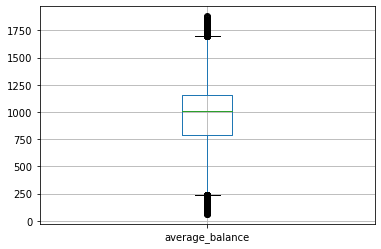

In [10]:
data_bal_iqr.boxplot(column=['average_balance'])

<AxesSubplot:>

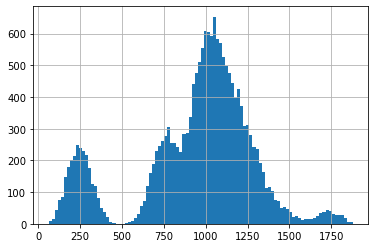

In [11]:
data_bal_iqr['average_balance'].hist(bins=100)

In [12]:
data_bal_iqr.shape

(17977, 13)

<AxesSubplot:>

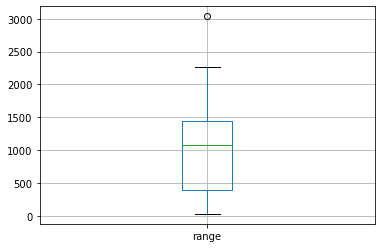

In [13]:
data_bal_iqr.boxplot(column=['range'])

In [14]:
iqr = np.percentile(data_bal_iqr['range'],75) - np.percentile(data_bal_iqr['range'],25)
upper_limit = np.percentile(data_bal_iqr['range'],75) + 1.5*iqr
lower_limit = np.percentile(data_bal_iqr['range'],25) - 1.5*iqr
range_iqr =data_bal_iqr[(data_bal_iqr['range']>lower_limit) & (data_bal_iqr['range']<upper_limit)]

<AxesSubplot:>

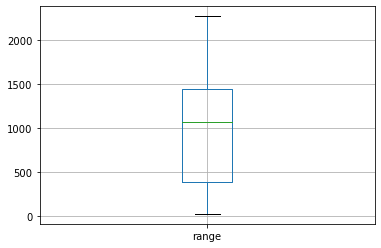

In [15]:
range_iqr.boxplot(column=['range'])

<AxesSubplot:>

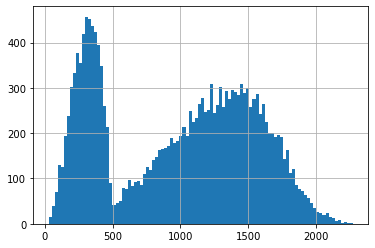

In [16]:
range_iqr['range'].hist(bins=100)

In [17]:
range_iqr.shape

(17976, 13)

In [18]:
data_clean_1 = range_iqr

In [45]:
data_clean_1.shape

(17976, 13)

In [19]:
data_clean_1.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,range
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,792.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,327.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,222.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1341.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,1775.0


Splitting numericals and categoricals again

In [20]:
cat_columns = []
num_columns = []

for i in data_clean_1.columns:
    if len(data_clean_1[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)   
num = data_clean_1[num_columns]
cat = data_clean_1[cat_columns]

Numericals - applying transformations, tested LOG transformation, BoxCox and Square Root

In [21]:
sqrt_bal_avg = num["average_balance"]**(1/2)

<AxesSubplot:>

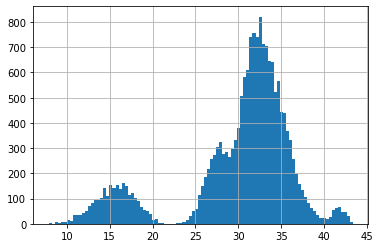

In [22]:
sqrt_bal_avg.hist(bins=100)

In [23]:
sqrt_rang = num["range"]**(1/2)

<AxesSubplot:>

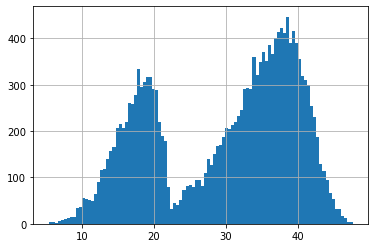

In [24]:
sqrt_rang.hist(bins=100)

BoxCox

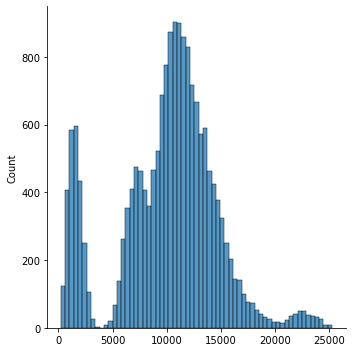

In [25]:
from scipy import stats
bal_cox, lmbda = stats.boxcox(num["average_balance"])
sns.displot(bal_cox)
plt.show()

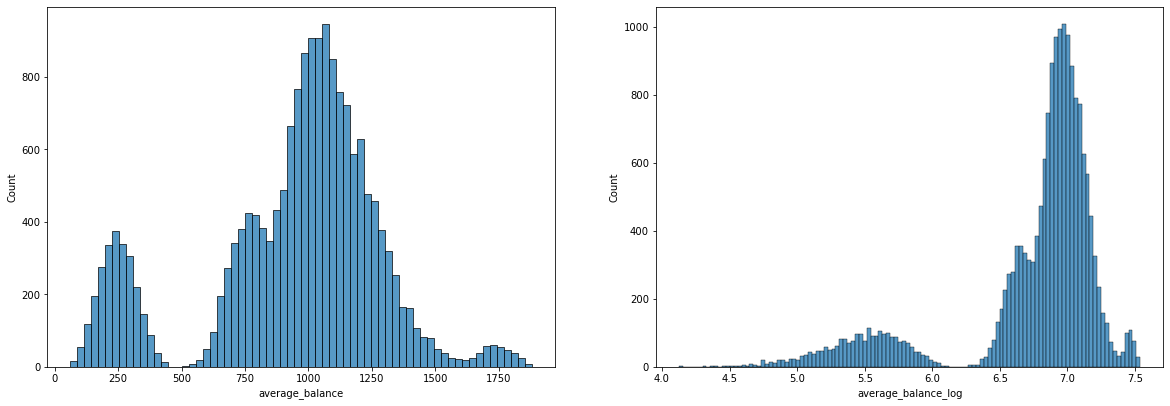

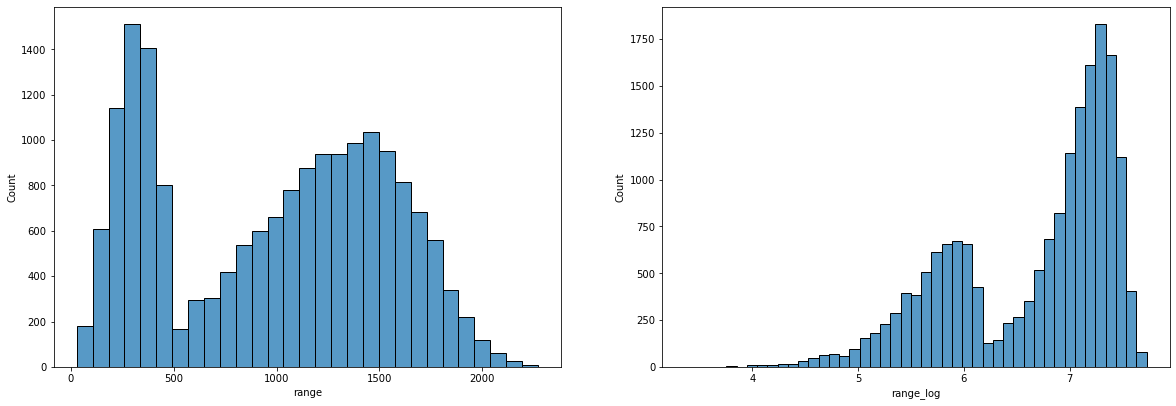

In [26]:
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  # in the code to be used with dataframe, we will use np.NaN here 
for x in num:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5)) 
    plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
    new_name = x + "_log"
    num[new_name] = list(map(log_transform_clean, num[x]))
    sns.histplot(num[x], ax=ax1)
    sns.histplot(num[new_name], ax=ax2)
    plt.show()

def box_cox_transform_clean(x):
    if x>0:
        return stats.boxcox(x)
    else:
        return 0  # in the code to be used with dataframe, we will use np.NaN here 
for x in num:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5)) 
    plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
    new_name = x + "box_cox"
    num[new_name] = list(map(box_cox_transform_clean, num[x]))
    sns.displot(num[x], ax=ax1)
    sns.displot(num[new_name], ax=ax2)
    plt.show()

We keep square root for Range and BoxCox for Average Balance

In [27]:
num["range"] = sqrt_rang


In [28]:
num["average_balance"] = bal_cox

In [29]:
num = num.drop(['average_balance_log', 'range_log'], axis=1)

Separate the ordinal categories from categorical

In [30]:
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


In [31]:
cat["income_level"]=cat["income_level"].apply(lambda x : 3 if x == "High" else(2 if x == "Medium" else 1))

In [32]:
cat["credit_rating"]=cat["credit_rating"].apply(lambda x : 3 if x == "High" else(2 if x == "Medium" else 1))

In [33]:
cat["own_your_home"] = cat["own_your_home"].apply(lambda x : 1 if x == "Yes" else 0)

In [34]:
cat["overdraft_protection"] = cat["overdraft_protection"].apply(lambda x : 1 if x == "Yes" else 0)

In [35]:
ord_cat = cat.select_dtypes(exclude = object)

In [36]:
ord_cat.head()

,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,3,1,0,3,2,1,4,0
1,2,1,0,2,2,2,5,1
2,3,2,0,2,2,1,2,1
3,2,2,0,3,1,1,4,0
4,2,1,0,2,2,1,6,1


Encoding Nominal Categoricals - OneHot Encoder + concat with Scaled Numerical

In [37]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
enc = OneHotEncoder(handle_unknown='error', drop='first')
enc_cat = pd.DataFrame(enc.fit_transform(cat[['reward', 'mailer_type']]).toarray())

In [39]:
data_enc = pd.DataFrame(np.concatenate([enc_cat,num, ord_cat], axis =1))

In [40]:
data_enc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.0,12942.928073,28.142495,3.0,1.0,0.0,3.0,2.0,1.0,4.0,0.0
1,0.0,0.0,0.0,735.941678,18.083141,2.0,1.0,0.0,2.0,2.0,2.0,5.0,1.0
2,0.0,0.0,1.0,1765.882501,14.899664,3.0,2.0,0.0,2.0,2.0,1.0,2.0,1.0
3,0.0,0.0,0.0,13853.340696,36.619667,2.0,2.0,0.0,3.0,1.0,1.0,4.0,0.0
4,0.0,0.0,0.0,13727.284133,42.130749,2.0,1.0,0.0,2.0,2.0,1.0,6.0,1.0


In [41]:
data_enc.shape

(17976, 13)

In [57]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(data_enc)
x_standardized = transformer.transform(data_enc)
print(x_standardized.shape)

(17976, 13)


In [58]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(data_enc)
x_normalized = transformer.transform(data_enc)
print(x_normalized.shape)

(17976, 13)


In [63]:
y = data_clean_1['offer_accepted']
X = x_normalized

In [84]:
data_preprocessed = pd.DataFrame(np.concatenate([X,pd.DataFrame(y)],axis=1))

In [85]:
data_preprocessed.to_csv('data_preprocessed.csv', index=False)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [77]:
y_train.value_counts()

No     10191
Yes      594
Name: offer_accepted, dtype: int64

Checking StandardScaler vs Normalizer

In [69]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)
y_train.value_counts()

No     10191
Yes    10191
Name: offer_accepted, dtype: int64

In [78]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
# fit predictor and target variable
X_train, y_train = ros.fit_resample(X_train, y_train)
y_train.value_counts()

No     10191
Yes    10191
Name: offer_accepted, dtype: int64

In [80]:
# from imblearn.under_sampling import TomekLinks

# tl = TomekLinks('majority')
# X_train, y_train = tl.fit_sample(X_train, y_train)
# y_train.value_counts()

No     9954
Yes     594
Name: offer_accepted, dtype: int64

In [44]:
X_num_normalized

NameError: name 'X_num_normalized' is not defined

In [ ]:
X_num_normalized = pd.DataFrame(X_num_normalized, columns = X_num.columns)